In [2]:
import torch
import torch.nn as nn
from torch.optim import SGD
from torch.func import vmap, jacrev, functional_call

import numpy as np
import matplotlib.pyplot as plt

In [3]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_hidden_layer):
        super(NeuralNet, self).__init__()
        self.hidden = nn.ModuleList()
        self.input_layer = nn.Linear(input_size, hidden_size)
        for k in range(num_hidden_layer-1):
            self.hidden.append(nn.Linear(hidden_size, hidden_size))
        self.output_layer = nn.Linear(hidden_size, output_size)
        
    
    def forward(self, x):
        x=self.input_layer(x)
        x=x.relu()
        for layer in self.hidden:
            x=layer(x)
            x=x.relu()
        x=self.output_layer(x)
        return x

def ReLU_standard_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(0, np.sqrt(2/len(param)))

def ReLU_glorot_init(model):
    for name, param in model.named_parameters():
        
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            nn.init.xavier_normal_(param)

In [4]:
d=1028
k=1000
hidden_units=128
num_hidden_layers=1

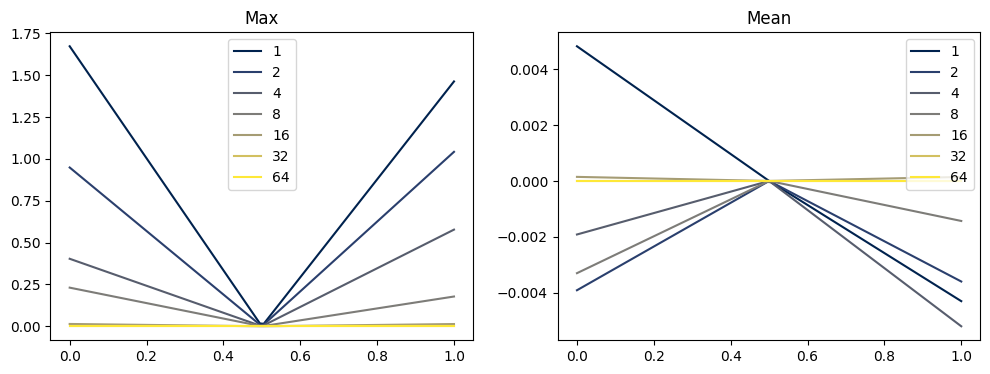

In [5]:
P_1=-np.ones(d)
P_2=np.ones(d)
x=torch.tensor(np.array([P_1+(P_2-P_1)*x for x in np.linspace(0,1,100)])).float()

fig, axs = plt.subplots(1,2)

fig.set_size_inches(12,4)

no_h_layers=[1,2,4,8,16,32,64]

colors = plt.cm.cividis(np.linspace(0, 1, len(no_h_layers)))

for n,h_layers in enumerate(no_h_layers):
    model=NeuralNet(d,hidden_units,k,h_layers)
    
    #ReLU_standard_init(model)
    #outputs=model(x)
    #y_max=[torch.max(torch.abs(ten)).detach().numpy() for ten in outputs]
    #y_mean=[torch.mean(ten).detach().numpy() for ten in outputs]
    #axs[0].plot(np.linspace(0,1,100),y_max,color='blue',alpha=1/(np.log2(h_layers)+1))
    #axs[1].plot(np.linspace(0,1,100),y_mean,color='blue',alpha=1/(np.log2(h_layers)+1))
    
    ReLU_glorot_init(model)
    outputs=model(x)
    y_max=[torch.max(torch.abs(ten)).detach().numpy() for ten in outputs]
    y_mean=[torch.mean(ten).detach().numpy() for ten in outputs]

    axs[0].plot(np.linspace(0,1,100),y_max,label=str(h_layers),color=colors[n])
    axs[1].plot(np.linspace(0,1,100),y_mean,label=str(h_layers),color=colors[n])

axs[0].set_title('Max')
axs[1].set_title('Mean')
axs[0].legend()
axs[1].legend()

plt.savefig('plots/ReLU_Function_Initialization.png')

In [6]:
def geometric_complexity(batch,model):
    gc=0
    N=len(batch)
    for ten in batch:
        J = torch.autograd.functional.jacobian(model, ten)
        gc+=np.linalg.norm(J)/N
    return gc

14.130070209503161
10.197602272033691
5.014634847640999
1.2440066933631893
0.08309422805905345
0.0004963784449500961
6.0286331482473245e-09


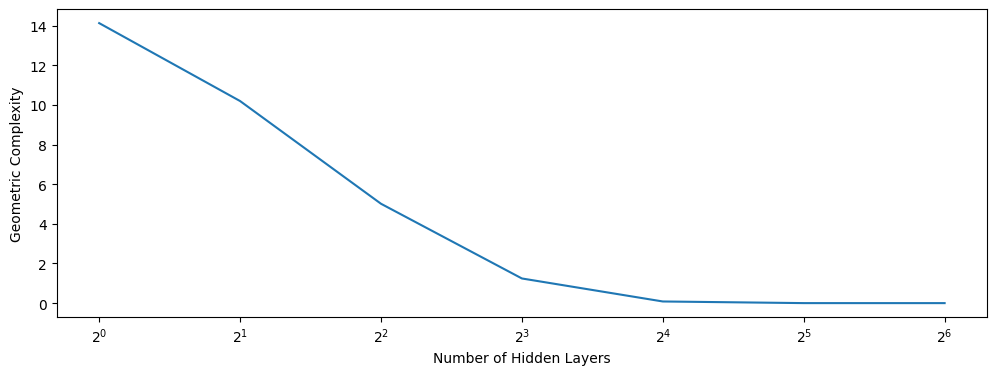

In [7]:
P_1=-np.ones(d)
P_2=np.ones(d)
x=torch.tensor(np.array([P_1+(P_2-P_1)*x for x in np.linspace(0,1,100)])).float()

fig, axs = plt.subplots(1,1)

fig.set_size_inches(12,4)

no_h_layers=[1,2,4,8,16,32,64]
gc=[]

for n,h_layers in enumerate(no_h_layers):
    model=NeuralNet(d,hidden_units,k,h_layers)
    
    ReLU_glorot_init(model)
    gc.append(geometric_complexity(x,model))
    print(gc[-1])

axs.plot(no_h_layers,gc)
axs.set_xscale('log',base=2)
axs.set_xlabel('Number of Hidden Layers')
axs.set_ylabel('Geometric Complexity')
plt.savefig('plots/Geometric_Complexity.png')